# Finite Difference Method 3: MODFLOW
## Mark Bakker
### Geohydrology II

### MODFLOW

MODFLOW is a finite different model for groundwater flow written and maintained by the U.S. Geological Survey. MODFLOW is likely the most popular computer program for groundwater modeling in the world. The code is free and public domain and available from the [USGS website](https://water.usgs.gov/ogw/modflow/mf2005.html). The USGS has released several different versions of MODFLOW since its original development in the 1980s. We will use MODFLOW 2005 v. 1.12 (MODFLOW6 was released last year, but MODFLOW2005 is the most used version at the moment). 

MODFLOW has a modular structure and is written in FORTRAN. Due to its modular structure, it is relatively easy to add code, called packages, to simulate a variety of different features in the aquifer. A list of packages included in the USGS MODFLOW version, including manuals, can be found [here](http://water.usgs.gov/ogw/modflow/MODFLOW.html). Online help for all the packages is available from [here](http://water.usgs.gov/ogw/modflow/MODFLOW.html).

MODFLOW simulates groundwater flow in multi-layer aquifer systems. Each layer consists of the same rectangular grid. The width of cells may vary for each row and the length of cells may very for each column, but the same horizontal grid must be used in each layer. 

MODFLOW requires the specification of a set of detailed input files. We will create these input files using Python and the FloPy package. Flopy is a set of Python scripts for writing MODFLOW data sets and reading MODFLOW binary output files. 
Flopy works for many MODFLOW packages including MT3DMS (for the simulation of contaminant transport) and SEAWAT (for the simulation of variable density flow). 

The structure of a MODFLOW model created with FloPy is as follows:
1. Create a MODFLOW model object
2. Define the discretization of the model
3. Define 'basic' model features, specifically which cells are inactive
4. Define the properties of the aquifer layers and, if present, leaky layers
5. Add packages to the MODFLOW model so simulate aquifer features
6. Define the solver that MODFOW uses to solve the model
7. Define what output MODFLOW needs to save to a file
8. Generate MODFLOW input files and solve the model (this will call the MODFLOW executable on your machine)
9. Read the binary output and display it

Before we start the example, we import `numpy`, `matplotlib`, and the `flopy` packages `modflow`, `utils` and `plot`.

In [1]:
%matplotlib inline
from pylab import *
import flopy.modflow as mf
import flopy.utils as fu
import flopy.plot as fp

### Example: Simple model with a few head-specified cells
As an example, we will create a  model for steady flow to a lake in a one-layer system. We call the model `lake_example`. *Note that the `modelname` cannot have spaces as it will be used as a filename*. We create a rectangular model with a specified head equal to `h1` along all boundaries. The head at the cell in the center in the top layer is fixed to `h2` (this is the lake). The following parameters are defined first: the name of the model, the number of rows `Nrow` and columns `Ncol`, the length `Ltot` and width `Wtot` of the sides of the model, the aquifer thickness `H`, and the hydraulic conductivity `k`

In [2]:
modelname = 'lake_example'
h1 = 100
h2 = 90
Nrow = 51
Ncol = 101
Ltot = 1000
Wtot = 500
H = 50
k = 1

All MODFLOW input files will be stored in a subdirectory called `data`. The code below checks whether this directory exists and if it doesn't it will be created.

In [3]:
import os
workspace = os.path.join('data')
# make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [4]:
workspace

'data'

*Step 1.* Create a MODFLOW model object. It is assumed that the MODFLOW binary is installed in the subdirectory `binpath`. Edit `binpath` so that is reflects the name of the correct subdirectory on your computer. 

In [5]:
import platform
binpath = 'C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling'  # Yes, also use forward slashes in Windows here
exe_name = os.path.join(binpath, 'mf2005')
if platform.system() == 'Windows':
    exe_name += '.exe'
print('Model executable: ', exe_name)

Model executable:  C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe


Create a `Modflow` instance and store it in a variale, in this case `ml`.

In [6]:
ml = mf.Modflow(modelname=modelname, 
                exe_name=exe_name, 
                model_ws=workspace)

*Step 2.* Discretization of the model

The following parameters need to be defined: 
* `nlay`: the number of layers
* `nrow`: the number of rows
* `ncol`: the number of columns
* `lenuni`: length units. default is 2, which means meters
* `delr`: the length of the cells along a row (one number or an array of length `ncol`)
* `delc`: the width of the cells along a colomn (one number or an array of length `nrow`)
* `top`: the elevation of the top of the aquifer system
* `botm`: a number (when there is one layer) or an array or list of the bottoms of the layers.
* `laycbd:`: a flag that indicates whether or not a layer has a semi-confining layer below it. 
  0 indicates no semi-confining layer, and not zero indicates a semi-cconfining layer. LAYCBD for the bottom layer must be 0. 
* `steady`: parameter that defines whether flow is steady or transient. In case of transient flow, additional parameters need to be specified.

In [7]:
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=Nrow,
                    ncol=Ncol,
                    lenuni=2,
                    delr=Ltot / (Ncol - 1),
                    delc=Wtot / (Nrow - 1),
                    top=0.0,
                    botm=-H,
                    laycbd=0,
                    steady=True) 

In [8]:
delr=Ltot / (Ncol - 1)
delr

10.0

*Step 3.* Basic features: inactive cells, fixed head cells, starting heads
    
The following parameters can be defined:
* `ibound`: an array indicating whether cells are inactive (0), fixed head equal to the supplied starting head (-1), or a regular active cell (1).
* `strt`: an array with the starting heads. Note that these values will also be used for any cells where `ibound=-1` (fixed head cells).

In [9]:
ic, jc = int((Nrow - 1) / 2), int((Ncol - 1) / 2) # index of the center
ibound = np.ones((Nrow, Ncol)) 
ibound[0, :] = -1; ibound[-1, :] = -1; ibound[:, 0] = -1; ibound[:, -1] = -1 
ibound[ic, jc] = -1 
start = h1 * np.ones((Nrow, Ncol)) 
start[ic, jc] = h2 
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)

The `ibound` array that you created may be visualized using the `modelmap` feature. First create a figure and an axis with `aspect` set to `equal`. Then create a `modelmap` object of the model, visualize the `ibound` array and the grid. Note that the lower-left corner of the lower-left cell is $(x,y)=(0,0)$.

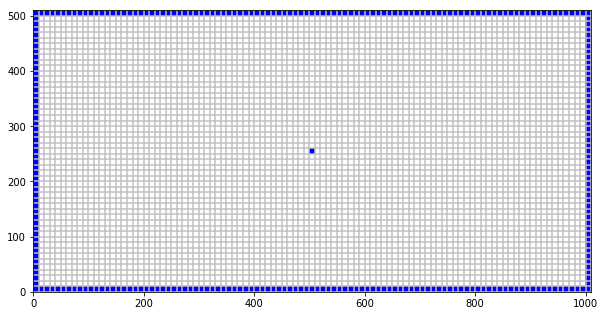

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_ibound()
modelmap.plot_grid(colors='silver');

*Step 4.* Set aquifer properties with the Layer Property Flow (LPF) package. 

Many things can be set here, but the most important one is the `hk` parameter, which represents the hydraulic conductivity of the cells in the row direction. The hydraulic conductivity in the column direction is the same unless the horizontal anisotropy is changed from its default value of 1

In [11]:
lpf = mf.ModflowLpf(ml, hk=k)

*Step 5.* No additional packages are added at this time. 

*Step 6.* Define the solver

A good solver for MODFLOW is the PCG solver, which performs a preconditioned conjugate-gradient solution. Information on this solver may be found [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

In [12]:
pcg = mf.ModflowPcg(ml)

*Step 7.* Output control

It can be defined what output MODFLOW saves to an output file. That can be convenient when there is a lot of output and you don't want to save everything. In this case, we simply want to save all heads for the steady model, which is the default.

In [13]:
oc = mf.ModflowOc(ml) 

*Step 8.* Write MODFLOW input files and run the model. This will only run when you have a MODFLOW executable on your machine and you have specified correctly where this routine is situated with the `exe_name` keyword when you created the `Modflow` model object in step 1.

In [14]:
ml.write_input()
ml.run_model()

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: lake_example.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:29

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:29
 Elapsed run time:  0.010 Seconds

  Normal termination of simulation


(True, [])

When the model runs correctly, and there were no errors in the input files, then the last message above should be 

`Normal termination of simulation`

The heads of the solution are stored in the file `modelname.hds`, where `modelname` is the name you specified when you created the `Modflow` model object in step 1. The heads may be loaded by first creating a `HeadFile`, and then reading the heads from this object by, for example, specifying the time. For steady flow the time is `1` and an array with shape `Nlay,Nrow,Ncol` is returned. Contouring may be carried out in the regular fashion, using `matplotlib`. The $x$ and $y$ (and $z$ if there are multiple layers) centers of the cells can be computed with the `get_node_coordinates` of the `ModflowDis` package. Note that the lower-left corner of the lower-left cell is $(x,y)=(0,0)$. *Note that the `get_node_coordinates` function returns y, x, z in that order.* 

In [15]:
os.path.join(workspace, modelname+'.hds')

'data\\lake_example.hds'

In [16]:
headfile = fu.HeadFile(os.path.join(workspace, modelname+'.hds'))
h = headfile.get_data(totim=1.0)
print('shape of h:', np.shape(h))
print('min,max of h:', h[0].min(), h[0].max()) 

shape of h: (1, 51, 101)
min,max of h: 90.0 100.0


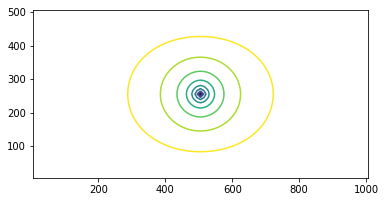

In [17]:
y, x, z = dis.get_node_coordinates()
plt.contour(x, y, h[0], levels=np.arange(90, 101, 1))
plt.axis('scaled');

Better yet, contouring can be carried out using the `modelmap` feature of `flopy`.

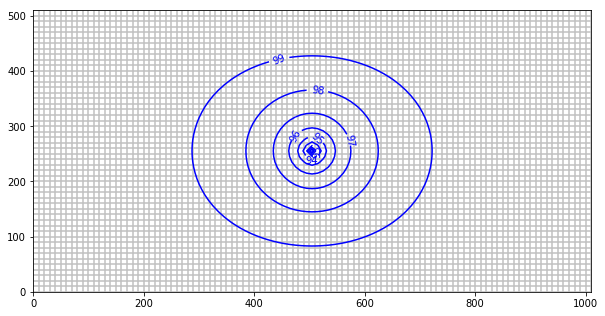

In [18]:
plt.figure(figsize=(10, 10))
plt.axis(aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_grid(colors='silver')
cs = modelmap.contour_array(h[0], levels=np.arange(90, 101, 1), colors='b')
plt.clabel(cs, fmt='%1.0f');

### Combined input file
All statements above are grouped together below. Note that you may again need to edit the path and name of your MODFLOW executable, as specified with the keyword `exe_name`, and the name of your subdirectory where you store the data files, as specified with the keyword `model_ws`. Running the cell below will create the same figure as above.

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: lake_example.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:31

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:31
 Elapsed run time:  0.015 Seconds

  Normal termination of simulation


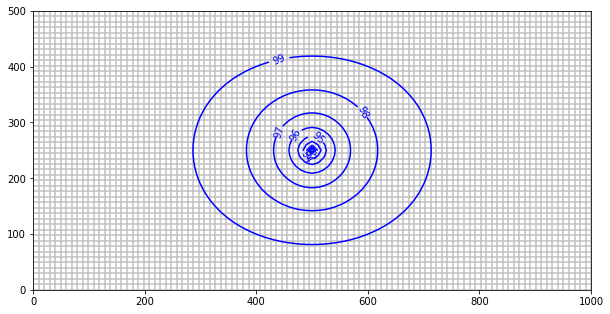

In [19]:
modelname = 'lake_example'
ml = mf.Modflow(modelname=modelname, 
                exe_name=exe_name, 
                model_ws=workspace)
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=Nrow,
                    ncol=Ncol,
                    lenuni=2,
                    delr=Ltot / Ncol,
                    delc=Wtot / Nrow,
                    top=0,
                    botm=-H,
                    laycbd=0) 
ibound = np.ones((1, Nrow, Ncol)) 
ibound[0, 0, :] = -1; ibound[0, -1, :] = -1; ibound[0, :, 0] = -1; ibound[0, :, -1] = -1 
ibound[0, ic, jc] = -1 
start = h1 * np.ones((Nrow, Ncol)) 
start[ic, jc] = h2 
bas = mf.ModflowBas(ml, ibound=ibound[0], strt=start)
lpf = mf.ModflowLpf(ml, hk=k)
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml) 
ml.write_input()
ml.run_model()
headfile = fu.HeadFile(os.path.join(workspace, modelname + '.hds'))
h = headfile.get_data(totim=1.0)
plt.figure(figsize=(10, 10))
plt.axis(aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_grid(colors='silver')
cs = modelmap.contour_array(h[0], levels=np.arange(90, 101, 1), colors='b')
plt.clabel(cs, fmt='%1.0f');

### Exercise 1. First model
Consider steady flow in a rectangular area. 
Create a rectangular model with 31 rows and 41 columns. The lengths of the cells along a row are 10 and the widths of the cells along a column are 5. The hydraulic conductivity is 10 m/d and the thickness is 20 m. The head is fixed to 70 m in the upper left-hand cell and to 90 in the lower right-hand cell. Solve this problem with MODFLOW and `flopy` and create a contour plot of the head.

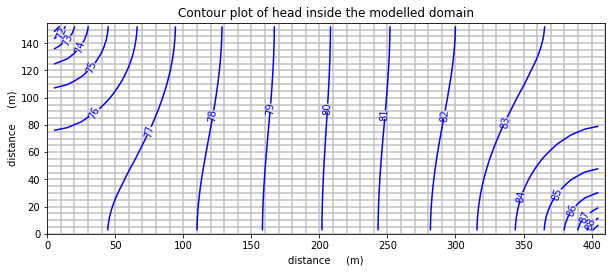

In [20]:
nrow = 31
ncol = 41
k = 10
H = 20
h_L = 70
h_R = 90
ml_1 = mf.Modflow(modelname='exercise1',
                  exe_name = exe_name,
                  model_ws = 'data')
dis = mf.ModflowDis(ml_1, nlay=1,
                    nrow=nrow, ncol=ncol,
                    lenuni=2, delr=10,
                    delc=5, top=0,
                    botm=-20, laycbd=0)
ibound = np.ones((nrow,ncol))
ibound[0,0] = -1
ibound[-1,-1] = -1
start = np.ones((nrow,ncol))
start[0,0] = h_L
start[-1,-1] = h_R
bas = mf.ModflowBas(ml_1, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml_1, hk=k)
pcg = mf.ModflowPcg(ml_1)
oc = mf.ModflowOc(ml_1)
ml_1.write_input()
ml_1.run_model(silent=True)
headfile = fu.HeadFile('data/exercise1.hds')
h = headfile.get_data(totim=1.0)
plt.figure(figsize=(10, 10))
plt.axis(aspect='equal')
modelmap = fp.ModelMap(model=ml_1)
modelmap.plot_grid(colors='silver')
cs = modelmap.contour_array(h[0], levels=np.arange(70, 90, 1), colors='b')
plt.title("Contour plot of head inside the modelled domain")
plt.xlabel('distance     (m)')
plt.ylabel("distance     (m)")
plt.clabel(cs, fmt='%1.0f');

### Recharge and unconfined flow
Recharge may be added to the model with the Recharge package, or the `Modflow.Rch` class of `flopy`. The Recharge package takes the keyword argument `rech`, which is the recharge in length / time (positive for going into the aquifer). Either one value (which is applied to all cells) or an array of `nrow` by `ncol` may be specified.
As an example, consider steady one-dimensional flow between two long, parallel canals. The canals are 1000 m apart. The canal on the left has a head $h=10$ m above the base of the aquifer and the canal on the right has a head $h=20$ m above the base of the aquifer. The hydraulic conductivity of the aquifer is 1 m/d. The recharge rate of the aquifer is 0.002 m/d. At first, heads are simulated using a constant aquifer thickness of $H=15$ m. 
A model is created as follows

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: recharge.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:34
 Elapsed run time:  0.004 Seconds

  Normal termination of simulation


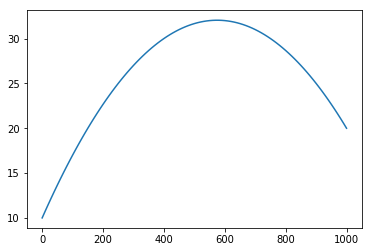

In [21]:
ml = mf.Modflow(modelname='recharge', 
                exe_name=exe_name, 
                model_ws='data')
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=1,
                    ncol=101,
                    lenuni=2,
                    delr=10.,
                    delc=1,
                    top=15,
                    botm=0,
                    laycbd=0)
ibound = np.ones((1, 101)) 
ibound[0, 0] = -1
ibound[-1, -1] = -1
start = np.zeros((1, 101)) 
start[0, 0] = 10
start[0, -1] = 20
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=1)
rch = mf.ModflowRch(ml, rech=0.002)
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml) 
ml.write_input()
ml.run_model()
headfile = fu.HeadFile('data/recharge.hds')
h = headfile.get_data(totim=1.0)
y, x, z = dis.get_node_coordinates()
x = x - x[0] # To set center of first node to zero
plt.plot(x, h[0,0]);

Next, the aquifer is made unconfined where the saturated thickness varies with the head. Three modifications need to be made to the model above. First, the top of the aquifer needs to be specified above the highest head that may be expected. Second, the keyword `laytyp` (layer type) needs to be specified in the LPF package. The layer type is by default 0, which means confined flow. When the layer type is larger than 0, flow is unconfined or, in MODFLOW lingo, *convertible*.  This means that MODFLOW will iterate until the saturated thickness is equal to the head minus the base, provided the head is below the top of the aquifer. Third, the starting heads need to be given a reasonable value, as these are used to start the iteration to find the correct saturated thickness. Starting with all zeros, except for the specified heads on the left and right, does not yield a proper solution. 

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: recharge.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:34
 Elapsed run time:  0.003 Seconds

  Normal termination of simulation
shape of h: (1, 1, 101)
min,max of h: 10.0 27.5918


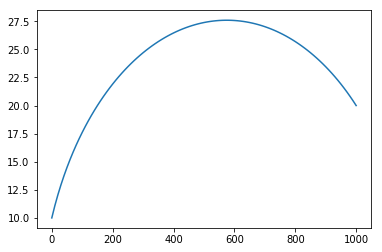

In [22]:
ml = mf.Modflow(modelname='recharge', 
                exe_name=exe_name, 
                model_ws=workspace)
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=1,
                    ncol=101,
                    lenuni=2,
                    delr=10,
                    delc=1,
                    top=30,
                    botm=0,
                    laycbd=0)
ibound = np.ones((1, 101)) 
ibound[0, 0] = -1
ibound[-1, -1] = -1
start = 10 * np.ones((1, 101)) 
start[0, 0] = 10
start[0, -1] = 20
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=1, laytyp=1)
rch = mf.ModflowRch(ml, rech=0.002)
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml) 
ml.write_input()
ml.run_model()
headfile = fu.HeadFile(os.path.join(workspace, 'recharge.hds'))
h = headfile.get_data(totim=1.0)
print('shape of h:', np.shape(h))
print('min,max of h:', h[0].min(), h[0].max()) 
y, x, z = dis.get_node_coordinates()
x = x - x[0] # To set center of first node to zero
plt.plot(x, h[0,0]);

### Wells

Wells may be added with the `ModflowWel` package (Note: only one `l` in `Wel`). As an example, consider a confined aquifer with a hydraulic conductivity $k=10$ m/d and thickness $H=20$ m. Develop a square model of 2000 by 2000 meter. A well is located at the center of a model that is 2000 by 2000 m. The discharge of the well is 1000 m$^3$/d. The head along the model boundary is fixed to $40$ m. A MODFLOW model is created of 51 by 51 square cells. The discharge of the well is specified with a Python `dictionary` of the following form:
```
stress_period_data =
{0: [
    [lay, row, col, discharge],
    [lay, row, col, discharge],
    [lay, row, col, discharge]
    ],
1:  [
    [lay, row, col, discharge],
    [lay, row, col, discharge],
    [lay, row, col, discharge]
    ], ...
kper:
    [
    [lay, row, col, discharge],
    [lay, row, col, discharge],
    [lay, row, col, discharge]
    ]
}
```
The keyword of each stress_period_data is the number of the stress period. For steady flow there is only one stress period with number 0 (more on stress periods when dealing with transient flow). In this case there is only 1 stress period, and there is only a well in layer 0, row 25, colum 25. The dischage is 1000 m$^3$/d, and since the well is pumping water out of the aquifer, it is specified as negative in MODFLOW, so that:
`stress_period_data = {0: [[0, 25, 25, -1000]]}`

In [23]:
ml = mf.Modflow(modelname = 'wells', 
                exe_name = exe_name, 
                model_ws = workspace)
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=51,
                    ncol=51,
                    lenuni=2,
                    delr=40,
                    delc=40,
                    top=0.0,
                    botm=-20.0,
                    laycbd=0)
ibound = np.ones((51, 51)) 
ibound[:, 0] = -1
ibound[:, -1] = -1
ibound[0, :] = -1
ibound[-1, :] = -1
start = np.full((51, 51), 40.0) 
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=10)
discharge_data ={0: [[0, 25, 25, -1000]]}
wel = mf.ModflowWel(ml, stress_period_data=discharge_data)
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml) 
ml.write_input()
ml.run_model()
headfile = fu.HeadFile(os.path.join(workspace, 'wells.hds'))
h = headfile.get_data(totim=1.0)
print('shape of h:', np.shape(h))
print('min,max of h:', h[0].min(), h[0].max()) 

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: wells.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:34
 Elapsed run time:  0.007 Seconds

  Normal termination of simulation
shape of h: (1, 51, 51)
min,max of h: 36.0916 40.0


A plot of the specified boundary conditions shows fixed heads along the edge of the model and one cell containing a well.

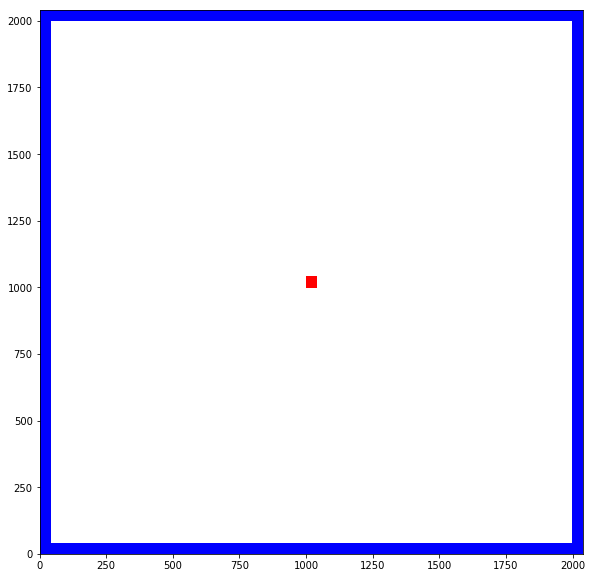

In [24]:
plt.figure(figsize=(10, 10))
plt.axis(aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_ibound()
modelmap.plot_bc('WEL', color='r');

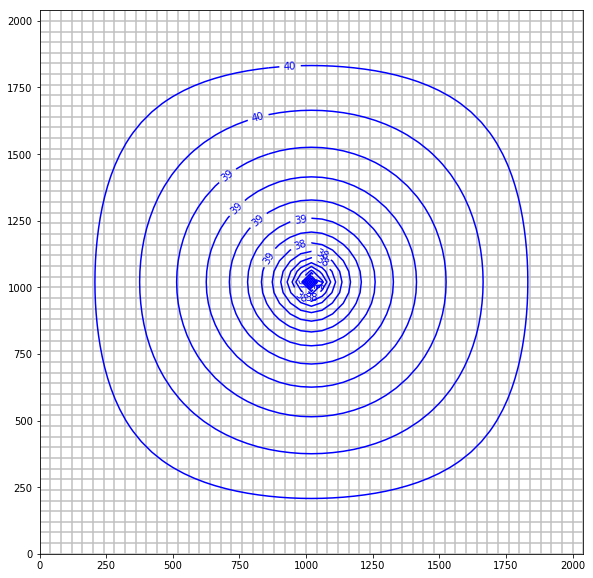

In [25]:
plt.figure(figsize=(10, 10))
plt.axis(aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_grid(colors='silver')
cs = modelmap.contour_array(h[0], levels = np.arange(36, 40.1, 0.2), colors='b')
plt.clabel(cs, fmt='%1.0f');

### List file

At this point it may be good to point out that all the output from MODFLOW is stored in a file called `workspace/modelname.list`, where `modelname` is the name you gave to the model. The file is stored in the directory that you defined for your workspace. You can open the file and look at it by going to the Jupyter Dashboard and clicking on the file. You can also look at it within this Notebook by typing the shell command: 

`more data/wells.list`. 

Type the command in a new code cell to get all the MODFLOW output. 

Whichever way you look at the List file, it is especially important to check the water balance to make sure that everything was solved accurately.

In [26]:
#more data/wells.list

### Exercise 2
Consider the model for a well in a rectangular area, as explained above. In reality, the well screen is only 2 m long and is placed at the bottom of the aquifer. Furthermore, the head is fixed along the edge of the model by a canal that is only 2 m deep. Modify the model developed above by discretizing the model in 10 layers of 2 m thickness.  `nlay` and `botm` need to be changed in the discretization package. `ibound` now needs to be a three-dimensional arrays of size `nlay, nrow, ncol`. `strt` also needs to be a three-dimensional array, unless the values are the same in each layer. Plot the head in the top layer and in the bottom layer along row 25.

In [42]:
ml = mf.Modflow(modelname = 'exercise2', 
                exe_name = exe_name, 
                model_ws = workspace)
dis = mf.ModflowDis(ml,
                    nlay=10,
                    nrow=51,
                    ncol=51,
                    lenuni=2,
                    delr=40,
                    delc=40,
                    top=0.0,
                    botm=np.arange(-2,-22,-2),
                    laycbd=0)
ibound = np.ones((10, 51, 51))
ibound[:,:, 0] = -1
ibound[:,:, -1] = -1
ibound[:,0, :] = -1
ibound[:,-1, :] = -1
start = np.full((10 ,51, 51), 2)
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=10)
discharge_data ={0: [[9, 25, 25, -1000]]}
wel = mf.ModflowWel(ml, stress_period_data=discharge_data)
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml)
ml.write_input()
ml.run_model()
headfile = fu.HeadFile(os.path.join(workspace, 'exercise2.hds'))
h = headfile.get_data(totim=1.0)
print('shape of h:', np.shape(h))
print('min,max of h:', h[0].min(), h[0].max())

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: exercise2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:17:39

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:17:39
 Elapsed run time:  0.085 Seconds

  Normal termination of simulation
shape of h: (10, 51, 51)
min,max of h: -0.914409 2.0


Text(0,0.5,'head    (m)')

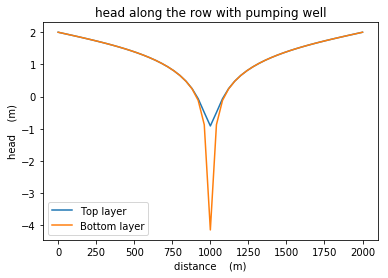

In [43]:
y, x, z = dis.get_node_coordinates()
x = x - x[0] # To set center of first node to zero
plt.plot(x, h[0,25,:],label='Top layer')
plt.plot(x, h[9,25,:],label='Bottom layer')
plt.title("head along the row with pumping well")
plt.legend()
plt.xlabel('distance    (m)')
plt.ylabel('head    (m)')

### Exercise 3
Create a model for a well near a straight river that runs from North to South along the Eastern boundary of the model. The model is 3000 m long and 2000 m wide. The river is located along the entire Eastern boundary. A well is located at $(x,y)=(2000,1000)$ and has discharge $Q=400$ m$^3$/d.  The groundwater flow is uniform towards the river in absence of the well with a gradient of $\partial h/\partial x = -0.002$. The aquifer is confined with $k=10$ m/d, and $H=20$ m.  The head in the river is 40 m. Use 41 rows and 61 columns. Note: the well data for a stress period may be specified as a two-dimensional array with four columns where the four columns are: layer, row, column, discharge. If this array is called `well_array` then the stress data may be specified as `{0: well_array}`. Create a contour plot of the head. What is the drawdown in the cell that contains the well?

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: exercise3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:21:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:21:59
 Elapsed run time:  0.017 Seconds

  Normal termination of simulation
drawdown at the well is 2.09 meter


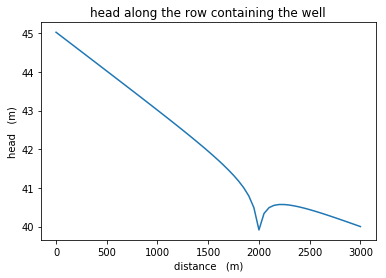

In [51]:
ml = mf.Modflow(modelname = 'exercise3',
                exe_name = exe_name,
                model_ws = workspace)
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=41,
                    ncol=121,
                    lenuni=2,
                    delr=50,
                    delc=50,
                    top=0.0,
                    botm=-20,
                    laycbd=0)
ibound = np.ones((41, 121))
ibound[:, -1] = -1
start = np.full((41, 121), 40)
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=10)
discharge_data ={0: [[0,20,20,0.002*200*50*41] ,[0, 20, 100, -400]]}
wel = mf.ModflowWel(ml, stress_period_data=discharge_data)
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml)
ml.write_input()
ml.run_model()
headfile = fu.HeadFile(os.path.join(workspace, 'exercise3.hds'))
h = headfile.get_data(totim=1.0)
y, x, z = dis.get_node_coordinates()
x = x - x[0] # To set center of first node to zero
plt.title("head along the row containing the well")
plt.plot(np.arange(0,3050,50),h[0,20,60:])
plt.xlabel("distance   (m)")
plt.ylabel("head   (m)")
print("drawdown at the well is %.2f meter"%(40+0.002*1000-h[0,20,100]))

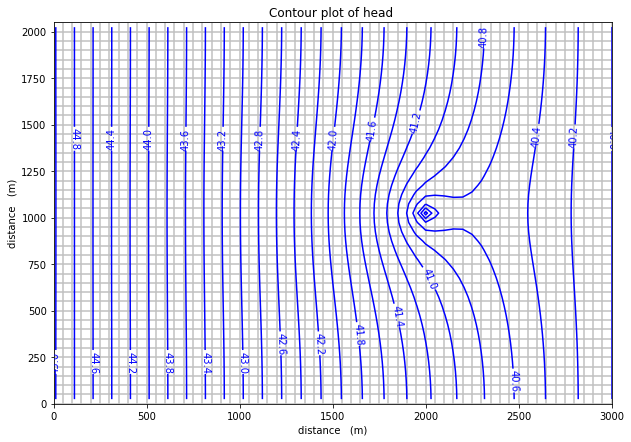

In [60]:
plt.figure(figsize=(10, 10))
plt.axis(aspect='equal')
plt.title("Contour plot of head ")
plt.xlabel("distance   (m)")
plt.ylabel("distance   (m)")
modelmap = fp.ModelMap(model=ml)
modelmap.plot_grid(colors='silver')
cs = plt.contour(np.arange(0,3050,50),y,h[0,:,60:], levels = np.arange(40, 46, 0.2), colors='b')
plt.xlim([0,3000])
plt.clabel(cs, fmt='%1.1f');

### Transient flow

Transient flow may be simulated by defining multiple stress periods. In each stress period, all specified features, such as recharge or wells, may change. When simulating transient flow, you obviously need to specify the storage coefficient of each layer. For example, let's take the solution for flow to a well in a single layer of a square model, as discussed above. Initially the head is equal to 40 everywhere. The well is turned on for 100 days and then turned off for 100 days. In the discretization package, two *stress periods* are defined. They are both 100 days long (`perlen`), both have 10 steps of equal length (`nstp`), and we need to specify that flow is not steady for each stress periods (`steady=False`). In th LPF package, the storage coefficient is 0.1 (phreatic storage). As we want to simulate flow with a constant transmissivity, we specify the specific storage as `ss = 0.1 / 20`, as 20 is the aquifer thickness. In the `stress_period_data` of the well, the value 0 is specified if there are no wells operational in that stress period. If nothing is specified for a stress period, the data from the last stress period when something was specified is used. In the output control, you need to specify at which times you want to save the heads (the default is only saving the head of the first stress period after the first time step). This is again specified using a `stress_period_data` dictionary, where you specify a tuple of `(stress period, time step)` and then what you want to do `[SAVE HEAD]`. In the code below, a loop is used to store the heads for all stress periods (there are 2) and for all time steps (10 time steps for each stress period). 
All the output data is read in one statement. Note that the head array is now of size `Ntimesteps, Nlay, Nrow, Ncol`. 

In [31]:
ml = mf.Modflow(modelname='transientwells', 
                exe_name=exe_name, 
                model_ws=workspace)
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=51,
                    ncol=51,
                    delr=40,
                    delc=40,
                    top=0.0,
                    botm=-20.0,
                    laycbd=0,
                    nper=2, 
                    perlen=[100, 100], 
                    nstp=[10, 10], 
                    steady=[False, False])
ibound = np.ones((51, 51)) 
start = np.full((51, 51), 40) 
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=10, ss=0.1 / 20)
discharge_data ={0: [[0, 25, 25, -1000]],
                 1: 0}
wel = mf.ModflowWel(ml, stress_period_data=discharge_data)
pcg = mf.ModflowPcg(ml)
stress_period_data = {}
for iper in range(2):
    for jstep in range(10):
        stress_period_data[(iper, jstep)] = ['SAVE HEAD']
oc = mf.ModflowOc(ml, stress_period_data=stress_period_data) 
ml.write_input()
ml.run_model(silent=True)
headfile = fu.HeadFile(os.path.join(workspace, 'transientwells.hds'))
h = headfile.get_alldata()
print('shape of h:', np.shape(h))

shape of h: (20, 1, 51, 51)


The data is plotted for four times

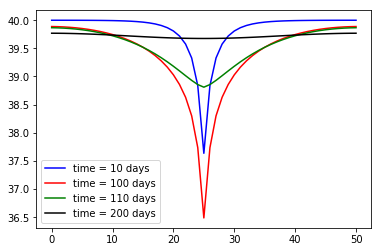

In [32]:
plt.plot(h[0, 0, 25, :], 'b', label='time = 10 days')
plt.plot(h[9, 0, 25, :], 'r', label='time = 100 days')
plt.plot(h[10, 0, 25, :], 'g', label='time = 110 days')
plt.plot(h[19, 0, 25, :], 'k', label='time = 200 days')
plt.legend(loc='best');

As all boundaries are impermeable, all the water pumped by the well should come from storage.

In [33]:
print('Total amount of water released from storage in 100 days:')
print(np.sum(40 - h[9, 0, :, :]) * 0.1 * 1600)

Total amount of water released from storage in 100 days:
100005.878906


### Exercise 4. Transient flow
Consider an unconfined aquifer with a hydraulic conductivity $k=10$ m/d, thickness $H=20$ m, and storage coefficient 0.1; use a constant transmissivity. Develop a square model of 2000 by 2000 meter. The head along the model boundary is fixed to $40$ m. The lower-left hand corner of the model is the origin. A pumping well is located at $(x,y)=(500,500)$ while an injection well is located at $(x,y)=(1500,1500)$. The discharge of the well is 1000 m$^3$/d for 100 days then off for 100 days, and keeps alternating like that. Similarly, the injection rate of the injection well is 1000 m$^3$/day for 100 days when the pumping well is not pumping, and is off when the pumping well is pumping.  Create a MODFLOW model using 41 by 41 square cells. Simulate 6 stress periods of 100 days. Make a contour plot of the head after 100 days, after 110 days, and after 200 days. In a separate figure, plot the head vs. time in the cell containing the pumping well and in the cell containing the injection well (together in one graph).

In [61]:
ml = mf.Modflow(modelname='exercise4', 
                exe_name=exe_name, 
                model_ws=workspace)
dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=41,
                    ncol=41,
                    delr=50,
                    delc=50,
                    top=0.0,
                    botm=-20.0,
                    laycbd=0,
                    nper=6, 
                    perlen=np.ones(6)*100, 
                    nstp=np.ones(6)*10, 
                    steady=np.zeros(6))
ibound = np.ones((41, 41)) 
ibound[:,0] = -1
ibound[:,-1] = -1
ibound[0,:] = -1
ibound[-1,:] = -1
start = np.full((41, 41), 40) 
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=10, ss=0.1 / 20)
discharge_data ={0: [[0, 30, 10, -1000]],
                 1: [[0,30,10,0],[0,10,30,1000]],
                 2: [[0,30,10,-1000],[0,10,30,0]],
                 3: [[0,30,10,0],[0,10,30,1000]],
                 4: [[0,30,10,-1000],[0,10,30,0]],
                 5: [[0,30,10,0],[0,10,30,1000]],
                 6: [[0,30,10,-1000],[0,10,30,0]]}
wel = mf.ModflowWel(ml, stress_period_data=discharge_data)
pcg = mf.ModflowPcg(ml)
stress_period_data = {}
for iper in range(6):
    for jstep in range(10):
        stress_period_data[(iper, jstep)] = ['SAVE HEAD']
oc = mf.ModflowOc(ml, stress_period_data=stress_period_data) 
ml.write_input()
ml.run_model(silent=True)
headfile = fu.HeadFile(os.path.join(workspace, 'exercise4.hds'))
h = headfile.get_alldata()
print('shape of h:', np.shape(h))

shape of h: (60, 1, 41, 41)


In [62]:
y, x, z = dis.get_node_coordinates()

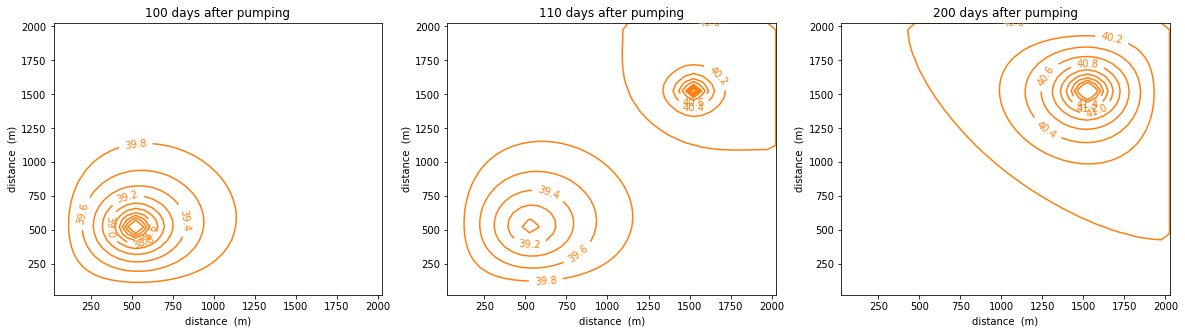

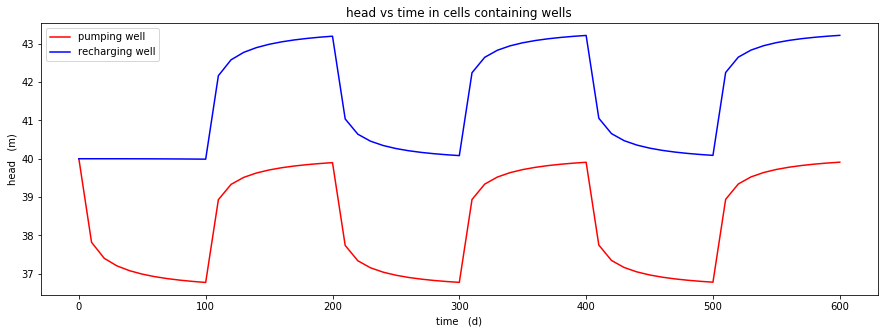

In [64]:
plt.figure(figsize=(20, 5))
plt.axis(aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_grid(colors='silver')
plt.subplot(131)
plt.title('100 days after pumping')
cs1 = plt.contour(x,y,h[9,0,:,:], levels = np.arange(38, 42, 0.2), colors='C1')
plt.xlabel('distance  (m)')
plt.ylabel('distance  (m)')
plt.clabel(cs1, fmt='%1.1f')
plt.subplot(132)
plt.title('110 days after pumping')
plt.xlabel('distance  (m)')
plt.ylabel('distance  (m)')
cs2 = plt.contour(x,y,h[10,0,:,:], levels = np.arange(38, 42, 0.2), colors='C1')
plt.clabel(cs2, fmt='%1.1f')
plt.subplot(133)
plt.title('200 days after pumping')
plt.xlabel('distance  (m)')
plt.ylabel('distance  (m)')
cs3 = plt.contour(x,y,h[19,0,:,:], levels = np.arange(38, 42, 0.2), colors='C1')
plt.clabel(cs3, fmt='%1.1f')
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,610,10),np.hstack((40,h[:,0,30,10])),label='pumping well',c='r')
plt.plot(np.arange(0,610,10),np.hstack((40,h[:,0,10,30])),label='recharging well',c='b')
plt.title("head vs time in cells containing wells")
plt.xlabel('time   (d)')
plt.ylabel('head   (m)')
plt.legend()
plt.show()


### General head boundary (GHB) cells
General head boundary (GHB) cells may be specified to simulate semi-confined flow. GHB cells are specified in a manner similar to wells: `stress_period_data` is specified, but now contains 5 items:
```
        stress_period_data =
        {0: [
            [lay, row, col, stage, cond],
            [lay, row, col, stage, cond],
            [lay, row, col, stage, cond],
            ],
        }
```
where `stage` is the water level $h^*$ and `cond` is the conductance such that the source term of the GHB cell is `cond` times the head differene $(h^*-h)$. If semi-confined flow is simulated, the leakage $N$ into the aquifer may be written as

$$N = \frac{h^*-h}{c}$$

such that the source term $Q$ equals

$$Q = LWN=\frac{LW}{c}(h^*-h)$$

where $L$ and $W$ are the length and width of the cell. Hence, the conductance equals the area of the cell divided by the resistance of the leaky layer.

### Exercise 5
Create a model for one-dimensional flow in a semi-confined aquifer that is bounded on the left by a canal with fixed water level $h=1$ m and extends to infinity on the right side. The head above the semi-confining layer is $h^*=0$ m. The hydraulic conductivity is $k=10$ m/d, the thickness of the aquifer is $H=20$ m, and the resistance of the leaky layer is $c=1000$ days. Compare the answer of your MODFLOW solution to the exact solution by making a graph that shows both. (You did the same in the Exercise of last week, so copy your exact solution from there.)

In [37]:
ml = mf.Modflow(modelname='exercise5', 
                exe_name=exe_name, 
                model_ws=workspace)

dis = mf.ModflowDis(ml,
                    nlay=1,
                    nrow=1,
                    ncol=1001,
                    delr=10,
                    delc=1,
                    top=0.0,
                    botm=[-20.0],
                    laycbd=0,
                    )
ibound = np.ones((1,1, 1001)) 
ibound[0,0,0] = -1
start = np.full((1,1, 1001), 1) 
bas = mf.ModflowBas(ml, ibound=ibound, strt=start)
lpf = mf.ModflowLpf(ml, hk=10)
bc = np.array([[0,0,0,0,10/1000]]*1000)
for i in range(1000):
    bc[i][2] = i+1
ghb_data ={0: bc}
ghb = mf.ModflowGhb(ml, stress_period_data=ghb_data)
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml)
ml.write_input()
ml.run_model()
headfile = fu.HeadFile(os.path.join(workspace, 'exercise5.hds'))
h = headfile.get_data(totim=1.0)

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: exercise5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:40

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/11 20:14:40
 Elapsed run time:  0.011 Seconds

  Normal termination of simulation


In [38]:
# Analytical
c = 1000
lab = np.sqrt(c*10*20)
X = np.linspace(0,10000,1001)
h_analytical = np.exp(-X/lab)

In [39]:
print(h_analytical,h[0,0,:])

[  1.00000000e+00   9.77887467e-01   9.56263899e-01 ...,   2.03377265e-10
   1.98880078e-10   1.94482336e-10] [  1.00000000e+00   9.77887928e-01   9.56264794e-01 ...,   3.85420945e-10
   3.85036003e-10   3.84843574e-10]


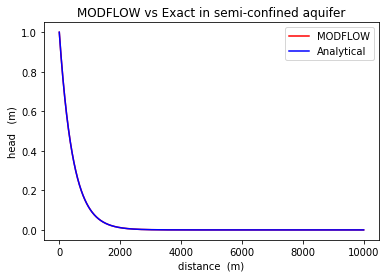

In [40]:
y, x, z = dis.get_node_coordinates()
plt.figure()
plt.plot(X,h[0,0,:],c='r',label='MODFLOW')
plt.plot(X,h_analytical,c='b', label = 'Analytical')
plt.title("MODFLOW vs Exact in semi-confined aquifer")
plt.xlabel("distance  (m)")
plt.ylabel("head   (m)")
plt.legend()
plt.show()